<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="33%"/>
  </p>
  
# **Trabajo Práctico 1: Reservas de Hotel**
### **Checkpoint**: 4
### **Grupo**: 11 - Los Pandas
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo
### **Integrantes**:
### 103456 - Labollita, Francisco
### 102312 - Mundani Vegega, Ezequiel
###  97263 - Otegui, Matías Iñaki

### Carga inicial de dependencias y datos

In [147]:
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
#import dtreeviz
import warnings

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import StandardScaler, MinMaxScaler

##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#Import Keras and Tensor
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.regularizers import l2

#Random Seed
np.random.seed(1)
tf.random.set_seed(1)

warnings.filterwarnings('ignore', 'is_categorical_dtype is deprecated')
warnings.filterwarnings("ignore", "use_inf_as_na")

## Limpieza del dataset

In [97]:
hotels_df = pd.read_csv('hotels_train.csv')
hotels_df_backup = hotels_df.copy()

#Eliminación de columnas irrelevantes
hotels_df_mod = hotels_df.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)

#Eliminación de filas con valores nulos
hotels_df_mod = hotels_df_mod.dropna(subset=['country', 'distribution_channel', 'market_segment'])

#Eliminación de filas con outliers
hotels_df_mod = hotels_df_mod.drop(hotels_df_mod[hotels_df_mod['adults'] > 4].index)

#Agent sin definir es un valor válido, por lo que se reemplaza por Undefined
hotels_df_mod['agent'] = hotels_df_mod['agent'].astype(str)
hotels_df_mod['agent'] = hotels_df_mod['agent'].replace('nan', 'Undefined')

#Se crea la columna que dice si se asignó la habitación pedida
hotels_df_mod = hotels_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

hotels_df_mod.loc[hotels_df_mod['room_type_match'] == hotels_df_mod['assigned_room_type'], 'room_type_match'] = True
hotels_df_mod.loc[hotels_df_mod['room_type_match'] != hotels_df_mod['assigned_room_type'], 'room_type_match'] = False
hotels_df_mod['room_type_match'] = hotels_df_mod['room_type_match'].astype(bool)

#Se normalizan los valores de las columnas numéricas cuantitativas
scaler = MinMaxScaler(feature_range=(0,1))
for col in hotels_df_mod.select_dtypes(include=[np.number, "int64", "float64"]).columns:
    hotels_df_mod[col] = scaler.fit_transform(hotels_df_mod[[col]])

#One-hot encoding para las columnas categóricas
hotels_df_mod = pd.get_dummies(hotels_df_mod, columns=["hotel",
    "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type",
    "deposit_type", "customer_type", "agent", 'room_type_match' ], drop_first=True)

hotels_df_mod = hotels_df_mod.reindex(sorted(hotels_df_mod.columns), axis=1)

In [98]:
# Find the columns with data type 'bool'
bool_columns = hotels_df_mod.select_dtypes(include=['bool'])

# Convert the 'bool' columns to 'float64'
for column in bool_columns.columns:
    hotels_df_mod[column] = hotels_df_mod[column].astype('float64')

In [99]:
hotels_df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61681 entries, 0 to 61912
Columns: 499 entries, adults to total_of_special_requests
dtypes: float64(499)
memory usage: 235.3 MB


### Empiezo a crear el modelo

In [100]:
df_x = hotels_df_mod.drop(['is_canceled'], axis=1)
df_y = hotels_df_mod['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, train_size= 0.7, test_size=0.30, random_state=2)

In [101]:
d_in=len(df_x)
# Create a simple feedforward neural network
model = keras.Sequential([
    keras.layers.Dense(8, activation='relu', input_shape=(498,)),  # Input layer
    keras.layers.Dense(8, activation='relu'), 
    keras.layers.Dense(1, activation='sigmoid')  # Output layer 
])
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 8)                 3992      
                                                                 
 dense_133 (Dense)           (None, 8)                 72        
                                                                 
 dense_134 (Dense)           (None, 1)                 9         
                                                                 
Total params: 4073 (15.91 KB)
Trainable params: 4073 (15.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [102]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

cant_epochs=50
# Train the model
history = model.fit(x_train, y_train, epochs=cant_epochs, batch_size=32, validation_split=0.2)

# Evaluate the model on the test dataß
test_loss, test_accuracy, test_auc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy}')

Epoch 1/50
1080/1080 [==============================] - 1s 695us/step - loss: 0.4625 - accuracy: 0.7753 - auc: 0.8610 - val_loss: 0.3882 - val_accuracy: 0.8099 - val_auc: 0.9014
Epoch 2/50
1080/1080 [==============================] - 1s 552us/step - loss: 0.3726 - accuracy: 0.8154 - auc: 0.9091 - val_loss: 0.3622 - val_accuracy: 0.8202 - val_auc: 0.9138
Epoch 3/50
1080/1080 [==============================] - 1s 569us/step - loss: 0.3540 - accuracy: 0.8252 - auc: 0.9180 - val_loss: 0.3558 - val_accuracy: 0.8238 - val_auc: 0.9167
Epoch 4/50
1080/1080 [==============================] - 1s 531us/step - loss: 0.3450 - accuracy: 0.8303 - auc: 0.9222 - val_loss: 0.3493 - val_accuracy: 0.8231 - val_auc: 0.9191
Epoch 5/50
1080/1080 [==============================] - 1s 603us/step - loss: 0.3381 - accuracy: 0.8357 - auc: 0.9255 - val_loss: 0.3458 - val_accuracy: 0.8308 - val_auc: 0.9211
Epoch 6/50
1080/1080 [==============================] - 1s 596us/step - loss: 0.3333 - accuracy: 0.8373 - auc:

### Matriz de Confusion y otras métricas

579/579 [==============================] - 0s 256us/step
Matriz de confusión de los datos de prueba


Text(50.722222222222214, 0.5, 'True')

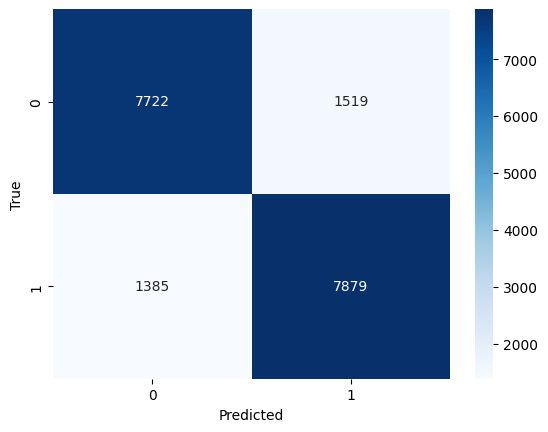

In [103]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

binary_predictions_test = (y_test_pred > 0.5).astype(int)
binary_predictions_train = (y_train_pred > 0.5).astype(int)

print("Matriz de confusión de los datos de prueba")
cm = confusion_matrix(y_test, binary_predictions_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [104]:
train_score = f1_score(y_train, binary_predictions_train)
test_score = f1_score(y_test, binary_predictions_test)

print("F1-Score sobre el set de entrenamiento:", round(train_score, 3))
print("F1-Score sobre el set de prueba:", round(test_score, 3))

F1-Score sobre el set de entrenamiento: 0.861
F1-Score sobre el set de prueba: 0.844


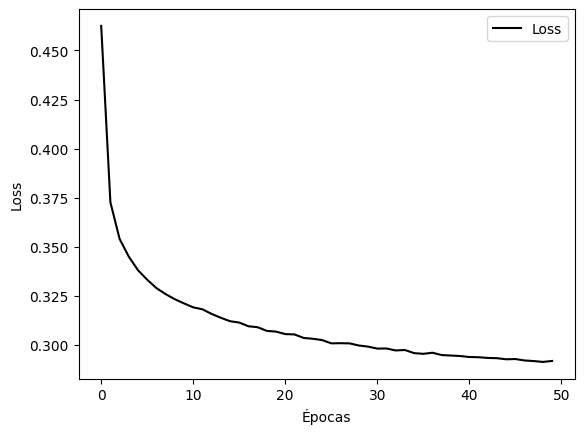

In [105]:
plt.plot(history.history['loss'], color='black', label='Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

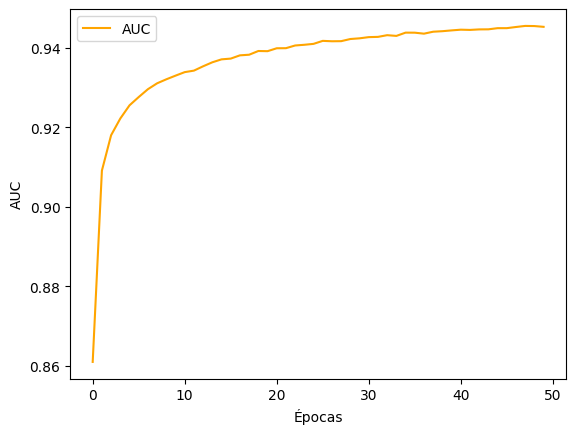

In [106]:
plt.plot(history.history['auc'], color='orange', label='AUC')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.show()

## Mejoro Modelo mediante un Grid Search

Híperparametros:
- Epochs
- Activation
- Optimizer

In [148]:
# Create the sklearn model for the network

def create_model():

    # Create a simple feedforward neural network
    model = keras.Sequential([
    keras.layers.Dense(8, activation='relu', input_shape=(498,), kernel_regularizer=l2(0.01)),  # Input layer
    keras.layers.Dense(8, activation='relu', kernel_regularizer=l2(0.01)), 
    keras.layers.Dense(1, activation='sigmoid')  # Output layer 
    ])

    model.compile(
      optimizer=keras.optimizers.SGD(learning_rate=0.001),
      loss='binary_crossentropy',
      # metricas para ir calculando en cada iteracion o batch
      metrics=['AUC'],
    )

    return model

In [ ]:
modelo_cv = KerasClassifier(build_fn=create_model)

params_grid = {
    'epochs': [100, 150, 200],
    #'neurons_per_layer': [3, 6, 9],
    #'activation': ['relu', 'sigmoid'],
    'batch_size': [5, 10, 15],
    'optimizer': ['nadam', 'adamax']
}

scorer_fn = make_scorer(f1_score)
kfoldcv = StratifiedKFold(n_splits=2)

gridcv = GridSearchCV(estimator=modelo_cv,
                      param_grid = params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv,
                      )

model = gridcv.fit(x_train,y_train)

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred)
print("Parámetros:", gridcv.best_params_, "\nF1 score: ", round(score, 3))

Luego de intentar agregar el hiperparamtro 'batch_size' al param_grid, se noto un costo computacional exponencial y no se logro mejorar el F1-Score del modelo. No se justifica usarlo.

In [120]:
modelo_cv = KerasClassifier(model=create_model)

params_grid = {
    'epochs': [175, 200],
    #'neurons_per_layer': [3, 6, 9],
    #'activation': ['relu', 'sigmoid'],
    #'batch_size': [5],
    'optimizer': ['nadam']
}

scorer_fn = make_scorer(f1_score)
kfoldcv = StratifiedKFold(n_splits=2)

gridcv = GridSearchCV(estimator=modelo_cv,
                      param_grid = params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv,
                      )

model = gridcv.fit(x_train,y_train)

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred)
print("Parámetros:", gridcv.best_params_, "\nF1 score: ", round(score, 3))

/Users/franciscolabollita/Library/Python/3.8/lib/python/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/175
675/675 [==============================] - 1s 735us/step - loss: 0.6988 - auc: 0.4833
Epoch 2/175
675/675 [==============================] - 0s 444us/step - loss: 0.6847 - auc: 0.6416
Epoch 3/175
675/675 [==============================] - 0s 398us/step - loss: 0.6795 - auc: 0.6880
Epoch 4/175
675/675 [==============================] - 0s 388us/step - loss: 0.6750 - auc: 0.7112
Epoch 5/175
675/675 [==============================] - 0s 388us/step - loss: 0.6699 - auc: 0.7292
Epoch 6/175
675/675 [==============================] - 0s 388us/step - loss: 0.6639 - auc: 0.7461
Epoch 7/175
675/675 [==============================] - 0s 387us/step - loss: 0.6570 - auc: 0.7608
Epoch 8/175
675/675 [==============================] - 0s 385us/step - loss: 0.6492 - auc: 0.7729
Epoch 9/175
675/675 [==============================] - 0s 387us/step - loss: 0.6405 - auc: 0.7828
Epoch 10/175
675/675 [==============================] - 0s 429us/step - loss: 0.6314 - auc: 0.7906
Epoch 11/175
675/67

/Users/franciscolabollita/Library/Python/3.8/lib/python/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/175
675/675 [==============================] - 0s 398us/step - loss: 0.6925 - auc: 0.5301
Epoch 2/175
675/675 [==============================] - 0s 427us/step - loss: 0.6865 - auc: 0.6234
Epoch 3/175
675/675 [==============================] - 0s 388us/step - loss: 0.6758 - auc: 0.6971
Epoch 4/175
675/675 [==============================] - 0s 386us/step - loss: 0.6635 - auc: 0.7378
Epoch 5/175
675/675 [==============================] - 0s 387us/step - loss: 0.6523 - auc: 0.7570
Epoch 6/175
675/675 [==============================] - 0s 388us/step - loss: 0.6410 - auc: 0.7677
Epoch 7/175
675/675 [==============================] - 0s 386us/step - loss: 0.6292 - auc: 0.7765
Epoch 8/175
675/675 [==============================] - 0s 383us/step - loss: 0.6168 - auc: 0.7845
Epoch 9/175
675/675 [==============================] - 0s 454us/step - loss: 0.6041 - auc: 0.7917
Epoch 10/175
675/675 [==============================] - 0s 391us/step - loss: 0.5915 - auc: 0.7993
Epoch 11/175
675/67

/Users/franciscolabollita/Library/Python/3.8/lib/python/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
675/675 [==============================] - 0s 402us/step - loss: 0.6931 - auc: 0.5109
Epoch 2/200
675/675 [==============================] - 0s 399us/step - loss: 0.6897 - auc: 0.5884
Epoch 3/200
675/675 [==============================] - 0s 397us/step - loss: 0.6866 - auc: 0.6421
Epoch 4/200
675/675 [==============================] - 0s 392us/step - loss: 0.6833 - auc: 0.6788
Epoch 5/200
675/675 [==============================] - 0s 390us/step - loss: 0.6793 - auc: 0.7053
Epoch 6/200
675/675 [==============================] - 0s 389us/step - loss: 0.6744 - auc: 0.7270
Epoch 7/200
675/675 [==============================] - 0s 390us/step - loss: 0.6686 - auc: 0.7471
Epoch 8/200
675/675 [==============================] - 0s 390us/step - loss: 0.6617 - auc: 0.7643
Epoch 9/200
675/675 [==============================] - 0s 389us/step - loss: 0.6538 - auc: 0.7797
Epoch 10/200
675/675 [==============================] - 0s 390us/step - loss: 0.6449 - auc: 0.7924
Epoch 11/200
675/67

/Users/franciscolabollita/Library/Python/3.8/lib/python/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
675/675 [==============================] - 0s 410us/step - loss: 0.6935 - auc: 0.5164
Epoch 2/200
675/675 [==============================] - 0s 398us/step - loss: 0.6902 - auc: 0.5863
Epoch 3/200
675/675 [==============================] - 0s 398us/step - loss: 0.6864 - auc: 0.6471
Epoch 4/200
675/675 [==============================] - 0s 399us/step - loss: 0.6820 - auc: 0.6928
Epoch 5/200
675/675 [==============================] - 0s 397us/step - loss: 0.6772 - auc: 0.7221
Epoch 6/200
675/675 [==============================] - 0s 406us/step - loss: 0.6720 - auc: 0.7450
Epoch 7/200
675/675 [==============================] - 0s 395us/step - loss: 0.6663 - auc: 0.7610
Epoch 8/200
675/675 [==============================] - 0s 397us/step - loss: 0.6600 - auc: 0.7726
Epoch 9/200
675/675 [==============================] - 0s 399us/step - loss: 0.6532 - auc: 0.7812
Epoch 10/200
675/675 [==============================] - 0s 445us/step - loss: 0.6458 - auc: 0.7875
Epoch 11/200
675/67

/Users/franciscolabollita/Library/Python/3.8/lib/python/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/175
1350/1350 [==============================] - 1s 415us/step - loss: 0.6930 - auc: 0.5180
Epoch 2/175
1350/1350 [==============================] - 1s 408us/step - loss: 0.6883 - auc: 0.6169
Epoch 3/175
1350/1350 [==============================] - 1s 404us/step - loss: 0.6836 - auc: 0.6732
Epoch 4/175
1350/1350 [==============================] - 1s 402us/step - loss: 0.6771 - auc: 0.7128
Epoch 5/175
1350/1350 [==============================] - 1s 408us/step - loss: 0.6688 - auc: 0.7448
Epoch 6/175
1350/1350 [==============================] - 1s 403us/step - loss: 0.6588 - auc: 0.7678
Epoch 7/175
1350/1350 [==============================] - 1s 410us/step - loss: 0.6472 - auc: 0.7847
Epoch 8/175
1350/1350 [==============================] - 1s 409us/step - loss: 0.6340 - auc: 0.7965
Epoch 9/175
1350/1350 [==============================] - 1s 424us/step - loss: 0.6194 - auc: 0.8062
Epoch 10/175
1350/1350 [==============================] - 1s 418us/step - loss: 0.6044 - auc: 0.8134

In [149]:
modelo_cv = KerasClassifier(model=create_model)

params_grid = {
    'epochs': [175],
    #'batch_size': [5],
    'optimizer': ['nadam', 'adam']
}

scorer_fn = make_scorer(f1_score)
kfoldcv = StratifiedKFold(n_splits=2)

gridcv = GridSearchCV(estimator=modelo_cv,
                      param_grid = params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv,
                      )

model = gridcv.fit(x_train,y_train, validation_split=0.2)

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred)
print("Parámetros:", gridcv.best_params_, "\nF1 score: ", round(score, 3))

Epoch 1/175
540/540 [==============================] - 1s 682us/step - loss: 0.9240 - auc: 0.4661 - val_loss: 0.9189 - val_auc: 0.4969
Epoch 2/175
540/540 [==============================] - 0s 491us/step - loss: 0.9151 - auc: 0.5105 - val_loss: 0.9115 - val_auc: 0.5317
Epoch 3/175
540/540 [==============================] - 0s 494us/step - loss: 0.9082 - auc: 0.5473 - val_loss: 0.9050 - val_auc: 0.5674
Epoch 4/175
540/540 [==============================] - 0s 500us/step - loss: 0.9018 - auc: 0.5793 - val_loss: 0.8987 - val_auc: 0.5946
Epoch 5/175
540/540 [==============================] - 0s 549us/step - loss: 0.8954 - auc: 0.6077 - val_loss: 0.8923 - val_auc: 0.6225
Epoch 6/175
540/540 [==============================] - 0s 508us/step - loss: 0.8889 - auc: 0.6339 - val_loss: 0.8857 - val_auc: 0.6469
Epoch 7/175
540/540 [==============================] - 0s 507us/step - loss: 0.8820 - auc: 0.6577 - val_loss: 0.8788 - val_auc: 0.6699
Epoch 8/175
540/540 [==============================] - 

Epoch 1/175
540/540 [==============================] - 1s 686us/step - loss: 0.9195 - auc: 0.5252 - val_loss: 0.9152 - val_auc: 0.5652
Epoch 2/175
540/540 [==============================] - 0s 499us/step - loss: 0.9116 - auc: 0.5852 - val_loss: 0.9068 - val_auc: 0.6256
Epoch 3/175
540/540 [==============================] - 0s 497us/step - loss: 0.9029 - auc: 0.6396 - val_loss: 0.8974 - val_auc: 0.6777
Epoch 4/175
540/540 [==============================] - 0s 498us/step - loss: 0.8934 - auc: 0.6834 - val_loss: 0.8877 - val_auc: 0.7125
Epoch 5/175
540/540 [==============================] - 0s 498us/step - loss: 0.8839 - auc: 0.7111 - val_loss: 0.8781 - val_auc: 0.7339
Epoch 6/175
540/540 [==============================] - 0s 496us/step - loss: 0.8741 - auc: 0.7319 - val_loss: 0.8681 - val_auc: 0.7508
Epoch 7/175
540/540 [==============================] - 0s 498us/step - loss: 0.8638 - auc: 0.7481 - val_loss: 0.8575 - val_auc: 0.7630
Epoch 8/175
540/540 [==============================] - 

Epoch 1/175
540/540 [==============================] - 1s 679us/step - loss: 0.9170 - auc: 0.6732 - val_loss: 0.9118 - val_auc: 0.7045
Epoch 2/175
540/540 [==============================] - 0s 497us/step - loss: 0.9079 - auc: 0.7126 - val_loss: 0.9026 - val_auc: 0.7287
Epoch 3/175
540/540 [==============================] - 0s 495us/step - loss: 0.8991 - auc: 0.7354 - val_loss: 0.8938 - val_auc: 0.7473
Epoch 4/175
540/540 [==============================] - 0s 495us/step - loss: 0.8905 - auc: 0.7490 - val_loss: 0.8850 - val_auc: 0.7575
Epoch 5/175
540/540 [==============================] - 0s 495us/step - loss: 0.8818 - auc: 0.7577 - val_loss: 0.8760 - val_auc: 0.7653
Epoch 6/175
540/540 [==============================] - 0s 493us/step - loss: 0.8728 - auc: 0.7644 - val_loss: 0.8666 - val_auc: 0.7724
Epoch 7/175
540/540 [==============================] - 0s 496us/step - loss: 0.8634 - auc: 0.7703 - val_loss: 0.8569 - val_auc: 0.7765
Epoch 8/175
540/540 [==============================] - 

Epoch 1/175
540/540 [==============================] - 1s 673us/step - loss: 0.9318 - auc: 0.4633 - val_loss: 0.9239 - val_auc: 0.5111
Epoch 2/175
540/540 [==============================] - 0s 502us/step - loss: 0.9201 - auc: 0.5240 - val_loss: 0.9156 - val_auc: 0.5616
Epoch 3/175
540/540 [==============================] - 1s 1ms/step - loss: 0.9128 - auc: 0.5649 - val_loss: 0.9089 - val_auc: 0.5949
Epoch 4/175
540/540 [==============================] - 0s 485us/step - loss: 0.9064 - auc: 0.5995 - val_loss: 0.9028 - val_auc: 0.6244
Epoch 5/175
540/540 [==============================] - 0s 483us/step - loss: 0.9004 - auc: 0.6275 - val_loss: 0.8967 - val_auc: 0.6509
Epoch 6/175
540/540 [==============================] - 0s 487us/step - loss: 0.8944 - auc: 0.6505 - val_loss: 0.8906 - val_auc: 0.6705
Epoch 7/175
540/540 [==============================] - 0s 485us/step - loss: 0.8883 - auc: 0.6707 - val_loss: 0.8845 - val_auc: 0.6886
Epoch 8/175
540/540 [==============================] - 0s

Epoch 1/175
1080/1080 [==============================] - 1s 572us/step - loss: 0.9252 - auc: 0.5499 - val_loss: 0.9160 - val_auc: 0.6111
Epoch 2/175
1080/1080 [==============================] - 1s 478us/step - loss: 0.9082 - auc: 0.6524 - val_loss: 0.9018 - val_auc: 0.6714
Epoch 3/175
1080/1080 [==============================] - 1s 477us/step - loss: 0.8943 - auc: 0.6969 - val_loss: 0.8881 - val_auc: 0.7055
Epoch 4/175
1080/1080 [==============================] - 1s 475us/step - loss: 0.8803 - auc: 0.7271 - val_loss: 0.8743 - val_auc: 0.7327
Epoch 5/175
1080/1080 [==============================] - 1s 475us/step - loss: 0.8659 - auc: 0.7524 - val_loss: 0.8597 - val_auc: 0.7555
Epoch 6/175
1080/1080 [==============================] - 1s 478us/step - loss: 0.8504 - auc: 0.7741 - val_loss: 0.8439 - val_auc: 0.7732
Epoch 7/175
1080/1080 [==============================] - 1s 476us/step - loss: 0.8343 - auc: 0.7871 - val_loss: 0.8280 - val_auc: 0.7845
Epoch 8/175
1080/1080 [==================

### Métricas de mejor modelo

In [150]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

binary_predictions_test = (y_test_pred > 0.5).astype(int)
binary_predictions_train = (y_train_pred > 0.5).astype(int)

train_score = f1_score(y_train, binary_predictions_train)
test_score = f1_score(y_test, binary_predictions_test)

print("F1-Score sobre el set de entrenamiento:", round(train_score, 3))
print("F1-Score sobre el set de prueba:", round(test_score, 3))

579/579 [==============================] - 0s 259us/step
F1-Score sobre el set de entrenamiento: 0.817
F1-Score sobre el set de prueba: 0.809


## Predicción de hotels_test

Se modifica el dataset de test de manera similar al de train, para que el modelo obtenido pueda ser aplicado.

In [109]:
test_df = pd.read_csv('hotels_test.csv')
test_df_mod = test_df.copy()

# renombrar columna del dataframe de reserved_room_type a room_type_match
test_df_mod = test_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

test_df_mod.loc[test_df_mod['room_type_match'] == test_df_mod['assigned_room_type'], 'room_type_match'] = True
test_df_mod.loc[test_df_mod['room_type_match'] != test_df_mod['assigned_room_type'], 'room_type_match'] = False
test_df_mod['room_type_match'] = test_df_mod['room_type_match'].astype(bool)

test_df_mod['agent'] = test_df_mod['agent'].astype(str)

id_backup = test_df_mod[['id']].copy()

test_df_mod = test_df_mod.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)
test_df_mod = test_df_mod.drop(['reservation_status_date'], axis='columns') #Esta es la columna que no debería estar en el dataset de test

#Se normalizan los valores de las columnas numéricas cuantitativas
scaler = MinMaxScaler(feature_range=(0,1))
for col in test_df_mod.select_dtypes(include=[np.number, "int64", "float64"]).columns:
    test_df_mod[col] = scaler.fit_transform(test_df_mod[[col]])

#One-hot encoding para las columnas categóricas
test_df_mod = pd.get_dummies(test_df_mod, columns=["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type", "deposit_type", "customer_type", "agent", "room_type_match" ], drop_first=True)

#Se crean las columnas que están en el df para entrenar pero no en el df a predecir
for col in df_x.columns:
    if col not in test_df_mod.columns:
        test_df_mod[col] = False

#Se eliminan las columnas que están en el df para predecir pero no en el df para entrenar
for col in test_df_mod.columns:
    if col not in df_x.columns:
        test_df_mod = test_df_mod.drop(columns=[col])

test_df_mod = test_df_mod.reindex(sorted(test_df_mod.columns), axis=1)

/var/folders/sx/p4bbsw2947l2kjgww8lxntch0000gn/T/ipykernel_12531/3312754589.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_mod[col] = False
/var/folders/sx/p4bbsw2947l2kjgww8lxntch0000gn/T/ipykernel_12531/3312754589.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_mod[col] = False
/var/folders/sx/p4bbsw2947l2kjgww8lxntch0000gn/T/ipykernel_12531/3312754589.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

In [110]:
# Find the columns with data type 'bool'
bool_columns = test_df_mod.select_dtypes(include=['bool'])

# Convert the 'bool' columns to 'float64'
for column in bool_columns.columns:
    test_df_mod[column] = test_df_mod[column].astype('float64')

In [111]:
#Se realiza una predicción sobre test utilizando el modelo
y_pred = model.predict(test_df_mod)

predictions = pd.DataFrame()

predictions['id'] = id_backup['id'].values
predictions['is_canceled'] = y_pred.astype(int)

predictions.to_csv('sample_submission.csv', index=False)

830/830 [==============================] - 0s 254us/step
